In [1]:
import numpy as np
from astropy.table import Table
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
%matplotlib inline
%config InlineBackend.figure_format = "retina"
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
import torch
import pandas as pd
import numpy as np
import slamN
from sklearn.preprocessing import RobustScaler
import scipy

In [2]:
train_dir = "data/"

scaler_sed = RobustScaler(quantile_range=(2.5, 97.5))
scaler_labels = RobustScaler(quantile_range=(2.5, 97.5))

data = np.load(f"{train_dir}/sed_CSSTtrain.npz", allow_pickle=True)
sed, labels = data['sed'], data['labels'][:,:5]


sed_norm = scaler_sed.fit_transform(sed)
labels_norm = scaler_labels.fit_transform(labels)

In [3]:
# from laspec.slam import NNModel
from slamN import NNModel
import torch
# initialize model

nnm = NNModel(n_label=5, n_pixel=7, n_hidden=32, n_layer=3, drop_rate=0.0001, wave=None)
nnm = torch.load("model/slam_csst_sed_240606.pt", map_location=torch.device('cpu'))

# Predict new labels based on trained forward model (N-SLAM) & MLP initial guess

In [4]:
n_star = 1000

random_indices = np.random.choice(len(sed_norm), n_star, replace=False)

sed_test = sed_norm[random_indices]
labels_test = labels_norm[random_indices]

print(sed_test.shape, labels_test.shape)    


(1000, 7) (1000, 5)


## give a MLP initial guess

In [5]:
from slamN import MLP

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = MLP(input_size=7, hidden_size=64, output_size=5).to(device)


In [6]:
model = torch.load("model/mlp_csst_sed_v240606.pt", map_location=device)

with torch.no_grad():
    ini_guess = model(torch.tensor(sed_test, device=device).float())

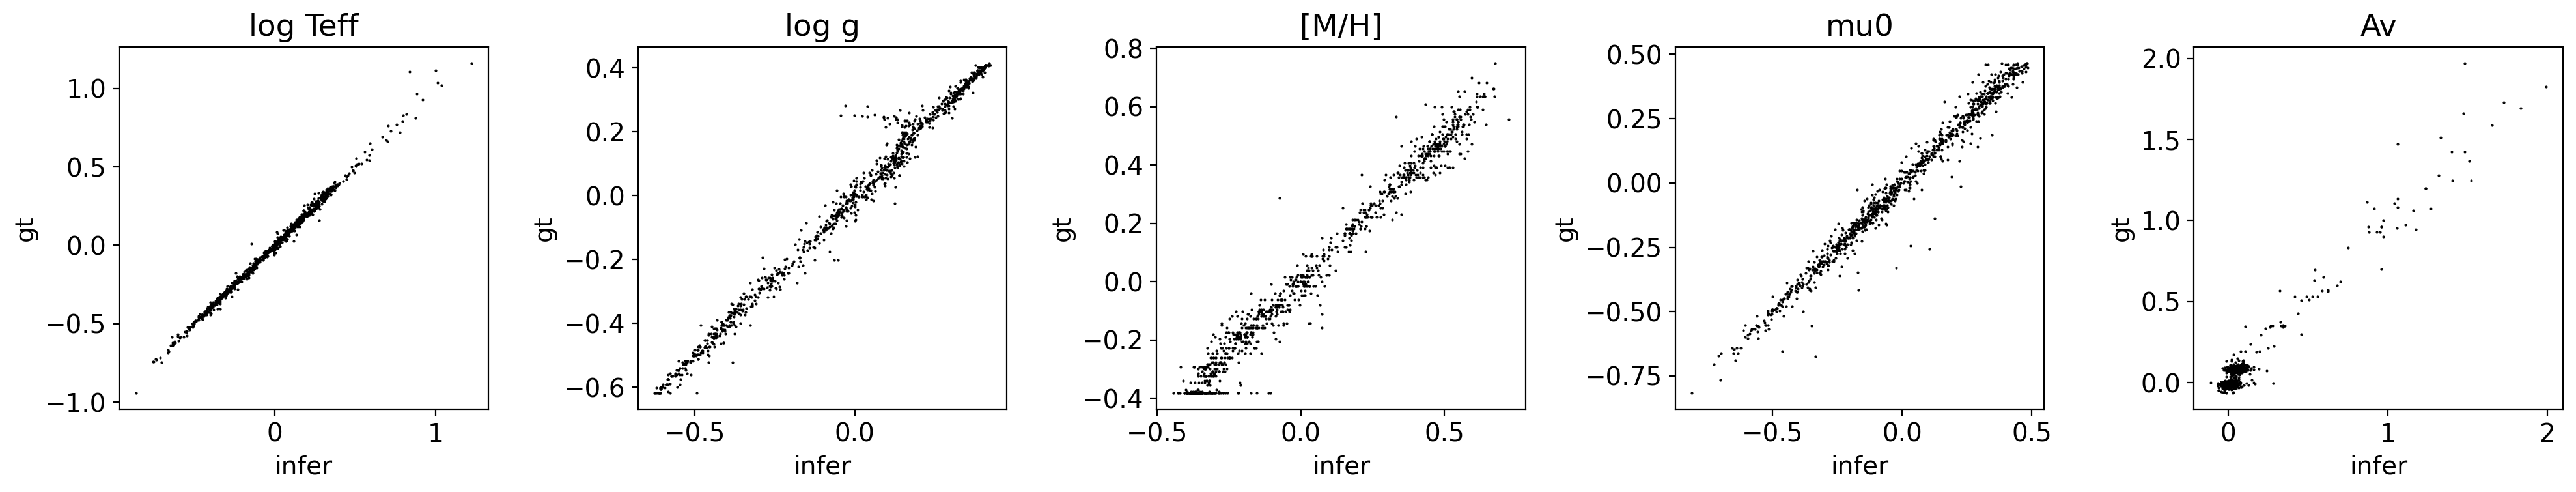

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    
    ax[i].plot(ini_guess[:, i], labels_test[:, i], ".", ms=1, c='k')
    ax[i].set_xlabel("infer")
    ax[i].set_ylabel("gt")
    ax[i].set_title(["log Teff", "log g", "[M/H]", "mu0", "Av"][i])

    # ax[i].set_xlim(np.min(labels_test_org[:, i]), np.max(labels_test_org[:, i]))
    # print(np.std(xpred_org[:, i]-labels_test_org[:, i]))

plt.tight_layout()

## now fitting the forward model by MLP inital guess

In [8]:
from scipy.optimize import least_squares
import joblib
from slamN import SlamPredictor

w = [nnm.state_dict_best[k].cpu().numpy() for k in nnm.state_dict_best.keys() if "weight" in k]
b = [nnm.state_dict_best[k].cpu().numpy()[:, None] for k in nnm.state_dict_best.keys() if "bias" in k]
alpha = 0.01 if nnm.activation == "relu" else 1.0
xmin = nnm.xmin
xmax = nnm.xmax



In [11]:
sp = SlamPredictor(w, b, alpha, xmin, xmax)
xpred_init = sp.least_squares_multiple(
    sed_test, n_jobs=4, 
    # p0=ini_guess.cpu().numpy(),
    p0=labels_test,
    verbose=5, 
    bounds=(np.ones(5)*-0.8, np.ones(5)*0.8)
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 108 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 648 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.3s finished


## error calculation

In [29]:
preds = np.array([_.x for _ in xpred_init])
preds = sp.scale_x_back(preds)
jacs = np.array([_.jac for _ in xpred_init])

def jacs_to_err(jac):
    U, s, Vh = scipy.linalg.svd(jac, full_matrices=False)
    tol = np.finfo(float).eps*s[0]*max(jac.shape)
    w = s > tol
    cov = (Vh[w].T/s[w]**2) @ Vh[w]  # robust covariance matrix
    perr = np.sqrt(np.diag(cov))     # 1sigma uncertainty on fitted parameters
    return perr

errs = np.array([jacs_to_err(jac) for jac in jacs])

flag_fit = np.array([_.success for _ in xpred_init])


0.011169027390101264
0.2239471131140136
0.20386968375146527
0.5956196421167803
0.1349403041713105


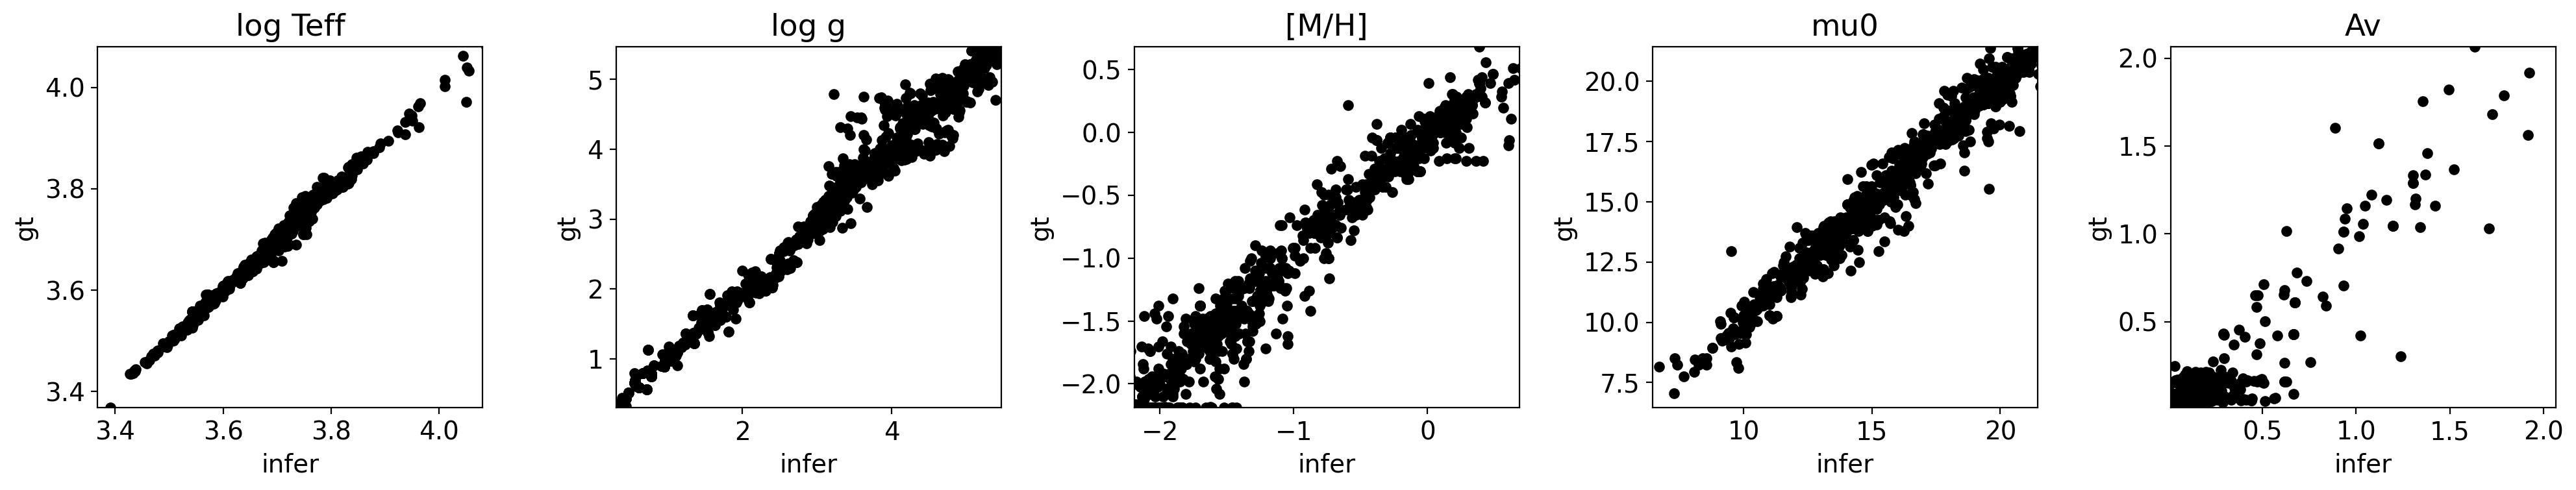

In [15]:
xpred_org = scaler_labels.inverse_transform(preds)
labels_test_org = scaler_labels.inverse_transform(labels_test[:n_star])

xpred_org_err = errs / scaler_labels.scale_

fig, ax = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    
    ax[i].plot(xpred_org[:, i], labels_test_org[:n_star][:, i], ".", ms=10, c='k')
    ax[i].set_xlabel("infer")
    ax[i].set_ylabel("gt")
    ax[i].set_title(["log Teff", "log g", "[M/H]", "mu0", "Av"][i])

    ax[i].set_xlim(np.min(labels_test_org[:, i]), np.max(labels_test_org[:, i]))
    ax[i].set_ylim(np.min(labels_test_org[:, i]), np.max(labels_test_org[:, i]))
    
    print(np.std(xpred_org[:, i]-labels_test_org[:, i]))

plt.tight_layout()

## save the prediction

id, logte, logg, mh, mu0, av, logte_err, logg_err, mh_err, mu0_err, av_err, , nuv0, u0, g0, r0, i0, z0, y0, flag, n_band  
  
flag_fit: 0, Fail; 1, Success

In [35]:
sed_intrin = sed_test - xpred_org.T[3][:, None] - xpred_org.T[4][:, None]

In [51]:
columns = [ 'logte', 'logg', 'mh', 'mu0', 'av', 
           'logte_err', 'logg_err', 'mh_err', 'mu0_err', 'av_err',
            'nuv0', 'u0', 'g0', 'r0', 'i0', 'z0', 'y0', 
            'flag_fit', 'n_band']


# Constructing the DataFrame
df = pd.DataFrame(
    np.concatenate([
        xpred_org, xpred_org_err, sed_test,
        (flag_fit * 1).reshape(-1, 1),  7*np.ones((n_star, 1))
    ], axis=1),
    columns=columns
)

# Setting dtype explicitly for each column
dtype_map = {
    'logte': np.float32, 'logg': np.float32, 'mh': np.float32, 'mu0': np.float32, 'av': np.float32,
    'logte_err': np.float32, 'logg_err': np.float32, 'mh_err': np.float32, 'mu0_err': np.float32, 'av_err': np.float32,
    'nuv0': np.float32, 'u0': np.float32, 'g0': np.float32, 'r0': np.float32, 'i0': np.float32, 'z0': np.float32, 'y0': np.float32,
    'flag_fit': np.int32, 'n_band': np.int32
}

for column, dtype in dtype_map.items():
    df[column] = df[column].astype(dtype)


In [52]:
df

,logte,logg,mh,mu0,av,logte_err,logg_err,mh_err,mu0_err,av_err,nuv0,u0,g0,r0,i0,z0,y0,flag_fit,n_band
0,3.521705,4.923953,0.265171,11.751066,0.115495,28.576937,9.202557,18.783852,2.457371,11.929385,0.376818,0.303335,0.258196,0.224207,0.150490,0.116425,0.105933,1,7
1,3.707628,2.443124,-1.280838,19.166588,0.143209,77.322739,10.302621,41.664722,2.484046,44.290684,-0.024846,-0.001067,0.034454,0.039033,0.039739,0.039304,0.039679,1,7
2,3.822241,4.716126,-1.436712,15.420495,0.180747,54.883018,33.695755,20.177319,9.394496,28.947140,-0.057992,0.004096,0.070121,0.095808,0.108159,0.114943,0.117901,1,7
3,3.758412,3.528051,-1.884879,15.293789,0.066610,84.748672,53.757004,174.724487,15.178446,46.477802,-0.190809,-0.140128,-0.084227,-0.069014,-0.061724,-0.057374,-0.055211,1,7
4,3.553865,0.439070,-0.105414,10.273687,0.211119,45.923191,4.522380,15.523796,1.186746,39.396637,-0.413174,-0.496647,-0.611230,-0.661853,-0.728197,-0.752481,-0.759234,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.458860,5.029323,-0.190221,9.624614,0.492512,13.528138,1.683589,22.297012,0.565692,45.955845,0.516031,0.449000,0.349448,0.304854,0.182321,0.129743,0.112987,1,7
996,3.838763,3.958638,0.212471,12.179912,0.089948,32.733337,9.581046,41.893646,3.036316,23.674274,-0.406009,-0.363729,-0.322879,-0.298939,-0.281488,-0.269670,-0.266137,1,7
997,3.511800,5.423474,-1.359141,12.290565,0.000179,13.466257,5.583966,25.910786,1.896260,21.217348,0.587618,0.555044,0.458577,0.398406,0.340999,0.314168,0.308529,1,7
998,3.564270,5.416285,-2.163994,13.813192,0.038045,13.208691,5.690181,25.757551,1.934769,20.610476,0.530978,0.507282,0.462066,0.419123,0.392367,0.376044,0.371822,1,7
